In [28]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from fimodemix.data.datasets import (
    route_to_ids,
    study_to_ids
)

from collections import namedtuple

FIMCompartementsDatabatchTuple = namedtuple(
    'FIMCompartementsDatabatchTuple',
    [
        'obs_values', 'hidden_values', 'obs_times',
        'dosing_values', 'dosing_times', 'dosing_routes', 'dosing_covariates',
        'diffusion_at_hypercube', 'drift_at_hypercube', 'hypercube_locations',
        'model_parameters', 'error_parameters', 'process_label', 'process_dimension'
    ]
)

# Set a seed for reproducibility
np.random.seed(1)

# Model definition
N = 1000  # number of individuals (IDs)
t_obs = np.array([0.5, 1, 2, 4, 8, 16, 24])  # sampling times
n_obs = len(t_obs)  # number of samples per ID

# Dosing scheme: i.v. bolus, single dose, flat
D = 100  # [mg]
route = "iv_bolus"

# Hyperparameters
fe = {'V': 20, 'CL': 3}  # fixed effects
sd_re = {'V': 0.4, 'CL': 0.3}  # standard deviation of random effects
sd_ruv = 0.2  # residual unexplained variability [mg/L]

# Individual parameters (log-normally distributed)
theta = np.zeros((N, 2))  # Matrix to hold individual parameters
for i in range(N):
    theta[i, 0] = fe['V'] * np.random.lognormal(mean=0, sigma=sd_re['V'])
    theta[i, 1] = fe['CL'] * np.random.lognormal(mean=0, sigma=sd_re['CL'])

print(theta[:5])  # First five individuals' parameters

[[38.30078603  2.4969884 ]
 [16.19113018  2.17433246]
 [28.27266185  1.50403377]
 [40.19155823  2.38750818]
 [22.72232479  2.78375623]]


In [68]:
# ========================================
# expressions / studies / 0 
# parameter realization / patients / 1 <-
# paths / occasion / 2 
# times / 3 <- 
# dimensions / 4 <-

# ODE right-hand side
def one_compartment_vf(y, t, param):
    V, CL = param
    dX = - CL / V * y  # ODE equation
    return dX

# ODE right-hand side
def one_dim_equivalent(x,t,param):
    h_theta(x,t) = f(x,y(t),z(t)) #<-----
    return dx

def full_system(x,y,z,param):
    dX = f(x,y,z)
    return dX

# Solving ODE and computing model prediction
obs_values = []
hidden_values = []
obs_time = []

dosing_values = []
dosing_times = []

for i in range(N):
    theta_i = theta[i, :]  # Individual's parameters
    x0 = [float(D)]  # Initial amount in plasma = dose
    dosing_time0 = [float(0.)]  # Initial amount in plasma = dose

    dosing_values.append(np.asanyarray(x0)[:])
    dosing_times.append(np.asanyarray(dosing_time0)[:])
    
    # Solve ODE: amount -> concentration (amount/volume)
    x_sol = odeint(one_compartment_vf, x0, np.concatenate([[0], t_obs]), args=(theta_i,)).squeeze()[:,None]
    noise = np.random.normal(0, sd_ruv, size=n_obs).squeeze()[:,None]
    hidden_values.append(x_sol[1:])
    obs_values.append((x_sol[1:] / theta_i[0]) + noise)  # Remove time 0 and convert to concentration
    obs_time.append(t_obs)

dosing_values = np.stack(dosing_values,axis=0)
hidden_values = np.stack(hidden_values,axis=0)

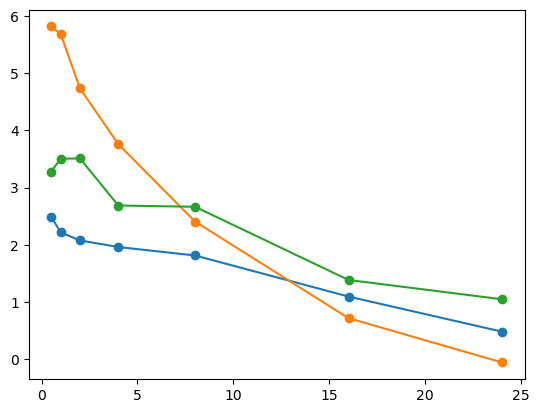

In [44]:
plt.plot(t_obs,obs_values[0],"o-")
plt.plot(t_obs,obs_values[1],"o-")
plt.plot(t_obs,obs_values[2],"o-")

In [24]:
theta_i

array([25.9113817 ,  4.54787444])

In [25]:
t_obs

array([ 0.5,  1. ,  2. ,  4. ,  8. , 16. , 24. ])

In [26]:
obs_values[0]

array([[2.52717654],
       [2.44612612],
       [2.29174014],
       [2.01158514],
       [1.54983169],
       [0.91997654],
       [0.54609596]])